In [25]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [26]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
df = pd.read_csv("./../data/supervised_1_1.csv")
print(df.shape)
df.set_index('date', inplace=True)
df.head()

(7316300, 22)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [34]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_lag = 1
n_seq = 1
reframed = series_to_supervised(scaled, n_lag, n_seq)
# drop the values from the final day for each station
reframed = reframed[reframed['var21(t-1)'] != 1]
# drop columns we don't want to predict
reframed.drop(reframed.columns[list(range(22,42))], axis=1, inplace=True)
# reframed.drop(reframed.columns[list(range(23,43))], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t)
1,0.614797,0.833333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,...,0.930292,0.921895,0.999172,0.146931,0.384615,0.0,0.837500,0.837223,0.000000,0.625740
2,0.625740,1.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,...,0.933953,0.927822,0.998255,0.088346,0.384615,0.0,0.879542,0.857262,0.001742,0.627907
3,0.627907,0.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,...,0.933953,0.927822,0.998255,0.095078,0.384615,0.0,0.889721,0.861439,0.003484,0.631408
4,0.631408,0.166667,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,...,0.935795,0.932700,1.000000,0.130423,0.384615,0.0,0.888849,0.861195,0.005226,0.639743
5,0.639743,0.333333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,...,0.931604,0.933425,0.994358,0.124376,0.384615,0.0,0.895463,0.862489,0.006969,0.628407


In [35]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# var21(t-1) is num_days
# var18(t-1) is station
n = 7303576
reframed.sort_values(by=['var21(t-1)', 'var18(t-1)'], inplace=True)
values = reframed.values
n_train_days = int(n*.95)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_seq], train[:, -n_seq]
test_X, test_y = test[:, :-n_seq], test[:, -n_seq]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6938397, 1, 21) (6938397,) (365179, 1, 21) (365179,)


Train on 6938397 samples, validate on 365179 samples
Epoch 1/10
 - 50s - loss: 0.0235 - val_loss: 0.0270
Epoch 2/10
 - 39s - loss: 0.0179 - val_loss: 0.0172
Epoch 3/10
 - 40s - loss: 0.0159 - val_loss: 0.0138
Epoch 4/10
 - 43s - loss: 0.0143 - val_loss: 0.0123
Epoch 5/10
 - 41s - loss: 0.0134 - val_loss: 0.0180
Epoch 6/10
 - 39s - loss: 0.0136 - val_loss: 0.0210
Epoch 7/10
 - 39s - loss: 0.0123 - val_loss: 0.0231
Epoch 8/10
 - 40s - loss: 0.0124 - val_loss: 0.0253
Epoch 9/10
 - 41s - loss: 0.0116 - val_loss: 0.0172
Epoch 10/10
 - 40s - loss: 0.0117 - val_loss: 0.0230


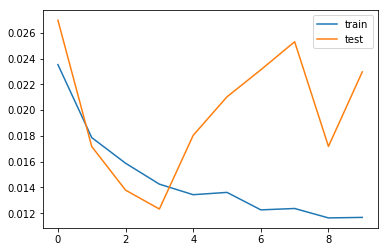

In [36]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_seq))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
# make a prediction
yhat = model.predict(test_X)

In [38]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.085


The LSTM is currently overfitting. Early stopping?